<a href="https://colab.research.google.com/github/peterbabulik/OTOCs/blob/main/OTOCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.2 MB/s eta 0:00:00


Hamiltonian for 6 qubits (shape: (64, 64)) created.
Simulating OTOC evolution...
Simulation complete!


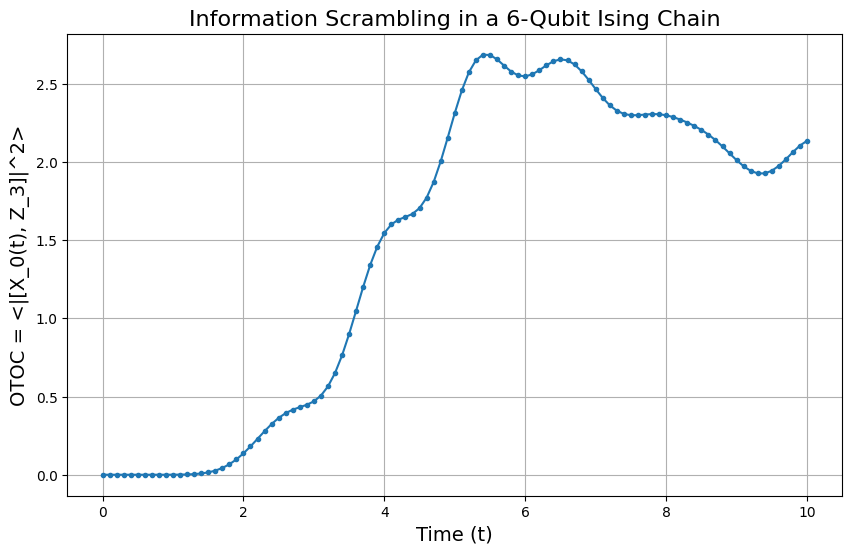

In [2]:
# Step 0: Install Cirq if you haven't already
# In Google Colab or Jupyter, run: !pip install cirq --quiet

import cirq
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# --- 1. Define the Quantum System (Transverse-Field Ising Model) ---
# This model is a standard choice for studying many-body quantum dynamics.
# The Hamiltonian is: H = -J Σ Z_i Z_{i+1} - h Σ X_i
# J is the interaction strength, and h introduces quantum fluctuations and chaos.

# System Parameters
N = 6          # Number of qubits (spins). Keep this small (< 10) for this exact simulation method.
J = 1.0        # Coupling strength (interaction term)
h = 0.5        # Transverse field strength (chaos-inducing term)

# Define Pauli Matrices, which are the building blocks of our operators
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

def get_full_system_operator(op, i, num_qubits):
    """
    Creates the matrix for a single-qubit operator acting on qubit 'i' in a larger system.
    Uses tensor products (np.kron) to create the full-size matrix.

    Args:
        op (np.array): The single-qubit operator (e.g., X, Z).
        i (int): The index of the qubit the operator acts on.
        num_qubits (int): The total number of qubits in the system.

    Returns:
        np.array: A (2**num_qubits, 2**num_qubits) matrix for the operator.
    """
    op_list = [I] * num_qubits
    op_list[i] = op

    full_op = op_list[0]
    for k in range(1, num_qubits):
        full_op = np.kron(full_op, op_list[k])

    return full_op

# Construct the Hamiltonian Matrix for the entire system
dim = 2**N
Hamiltonian = np.zeros((dim, dim), dtype=complex)

# Add interaction terms: -J * Z_i * Z_{i+1}
for i in range(N - 1):
    z_i = get_full_system_operator(Z, i, N)
    z_j = get_full_system_operator(Z, i + 1, N)
    Hamiltonian -= J * (z_i @ z_j)

# Add transverse field terms: -h * X_i
for i in range(N):
    x_i = get_full_system_operator(X, i, N)
    Hamiltonian -= h * x_i

print(f"Hamiltonian for {N} qubits (shape: {Hamiltonian.shape}) created.")


# --- 2. Define OTOC Operators and Initial State ---
# The OTOC measures how a local operator W spreads out and fails to commute with another distant operator V.
# We will measure C(t) = -<[W(t), V]^2>, where W(t) = U(t)† W U(t) is the time-evolved operator.

# Choose a simple local operator W (e.g., Pauli-X on the first qubit)
W = get_full_system_operator(X, 0, N)

# Choose a second local operator V at a different site (e.g., Pauli-Z in the middle)
m = N // 2
V = get_full_system_operator(Z, m, N)

# Use a simple initial state: all qubits in the |0> state, i.e., |00...0>
initial_state_ket = np.zeros(dim)
initial_state_ket[0] = 1
initial_state_ket = initial_state_ket.reshape(dim, 1) # Make it a column vector
initial_state_bra = initial_state_ket.conj().T        # Corresponding row vector


# --- 3. Simulate the Time Evolution and Calculate the OTOC ---
# We will loop through time, evolve the operator W(t), and compute the OTOC value.

time_steps = np.linspace(0, 10, 101) # An array of time points to calculate the OTOC for
otoc_values = []

print("Simulating OTOC evolution...")
for t in time_steps:
    # Calculate the time evolution operator U(t) = exp(-iHt) using matrix exponentiation.
    # This is an exact but computationally expensive method.
    U_t = expm(-1j * Hamiltonian * t)
    U_t_dagger = U_t.conj().T

    # Calculate the Heisenberg picture operator W(t) = U†(t) W U(t)
    W_t = U_t_dagger @ W @ U_t

    # Calculate the commutator: [W(t), V] = W(t)V - VW(t)
    commutator = (W_t @ V) - (V @ W_t)

    # We measure the OTOC as the expectation value of the squared commutator's norm.
    # C(t) = -<Ψ| [W(t), V]† [W(t), V] |Ψ>
    commutator_squared_norm = commutator.conj().T @ commutator

    expectation_value = (initial_state_bra @ commutator_squared_norm @ initial_state_ket)[0, 0]
    otoc_values.append(np.real(expectation_value))

print("Simulation complete!")


# --- 4. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_values, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC = <|[X_0(t), Z_{m}]|^2>", fontsize=14)
plt.title(f"Information Scrambling in a {N}-Qubit Ising Chain", fontsize=16)
plt.grid(True)
plt.show()

Instead of building a massive (2^N, 2^N) matrix for the Hamiltonian, we will now build a cirq.Circuit that approximates the time evolution by breaking it into a series of small, discrete time steps. This method is far more memory-efficient and allows us to simulate much larger systems.
The Concept: Trotter-Suzuki Decomposition
The core idea is to approximate the evolution operator U(t) = exp(-iHt). Since the different parts of our Ising Hamiltonian don't commute with each other, we can't simply exponentiate them separately. The Trotter-Suzuki formula gives us an approximation:
If H = A + B, then exp(-i(A+B)t) ≈ [exp(-iAΔt) * exp(-iBΔt)]^(t/Δt)
For our Ising model, we split the Hamiltonian H into three parts:
H_odd: Interactions between odd/even qubit pairs (Z_1Z_2, Z_3Z_4, ...)
H_even: Interactions between even/odd qubit pairs (Z_0Z_1, Z_2Z_3, ...)
H_field: The transverse field terms (X_0, X_1, ...)
Each of these parts contains only commuting terms, so we can easily create gates for them. A single "Trotter step" consists of applying the evolution for these three parts in sequence for a small time Δt. By repeating this step many times, we approximate the evolution for the total time t.


Simulating OTOC for 12 qubits with corrected logic (dt=0.01)...
Time: 0.50, OTOC: 0.0001
Time: 1.00, OTOC: 0.0002
Time: 1.50, OTOC: 0.0002
Time: 2.00, OTOC: 0.0002
Time: 2.50, OTOC: 0.0010
Time: 3.00, OTOC: 0.0089
Time: 3.50, OTOC: 0.0318
Time: 4.00, OTOC: 0.0486
Time: 4.50, OTOC: 0.0796
Time: 5.00, OTOC: 0.2400
Time: 5.50, OTOC: 0.3676
Time: 6.00, OTOC: 0.4072
Time: 6.50, OTOC: 0.7312
Time: 7.00, OTOC: 0.9708
Time: 7.50, OTOC: 0.9861
Time: 8.00, OTOC: 1.1731
Time: 8.50, OTOC: 1.2497
Time: 9.00, OTOC: 1.3009
Time: 9.50, OTOC: 1.3280
Time: 10.00, OTOC: 1.3123
Simulation complete!


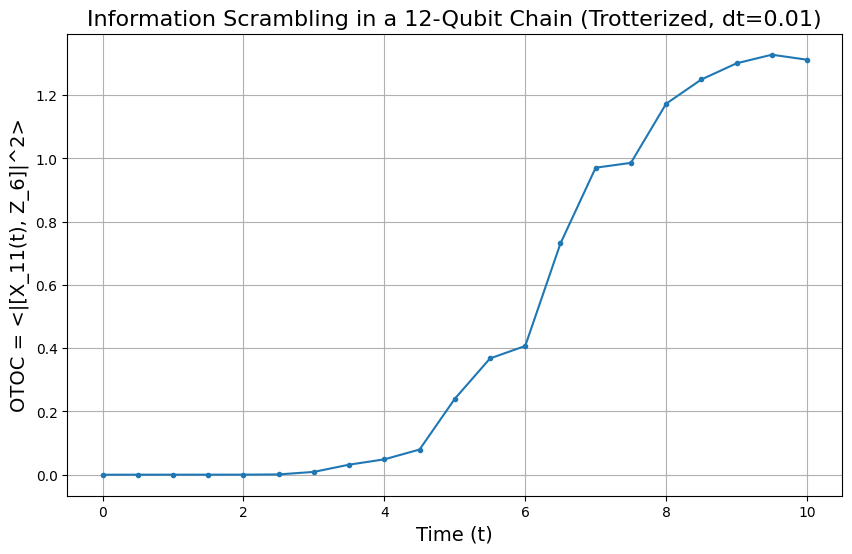

In [7]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the System and Trotter Gates ---
N = 12
J = 1.0
h = 0.5
qubits = cirq.LineQubit.range(N)

def trotter_step(qubits, J, h, dt):
    """Yields the gates for a single Trotter step."""
    N = len(qubits)
    for i in range(0, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(1, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(N):
        yield cirq.XPowGate(exponent=-2 * h * dt / np.pi).on(qubits[i])

# --- 2. Correct OTOC Simulation Logic ---
op_W = cirq.X
op_V = cirq.Z
w_site = N - 1
v_site = N // 2

total_time = 10.0
dt = 0.01  # A small dt is needed for accuracy
time_steps = np.arange(0, total_time + dt, dt * 50)
otoc_values_trotter = []

print(f"Simulating OTOC for {N} qubits with corrected logic (dt={dt})...")
simulator = cirq.Simulator()

# Handle t=0 case, where OTOC is 0
otoc_values_trotter.append(0.0)

for t in time_steps[1:]:
    num_trotter_steps = int(round(t / dt))
    if num_trotter_steps == 0: continue

    forward_evolution = cirq.Circuit(trotter_step(qubits, J, h, dt) for _ in range(num_trotter_steps))

    # Define the initial state |0...0>
    initial_state = np.zeros(2**N, dtype=np.complex64)
    initial_state[0] = 1.0

    # CORRECTED ALGORITHM: Calculate F(t) = Re(<ψ_a|ψ_b>)
    # where |ψ_a> = W(t)V|0> and |ψ_b> = VW(t)|0>

    # First, calculate |W(t)|0> = U(t)† W U(t) |0>
    psi_1 = simulator.simulate(forward_evolution, initial_state=initial_state, qubit_order=qubits).final_state_vector
    psi_2 = simulator.simulate(cirq.Circuit(op_W(qubits[w_site])), initial_state=psi_1, qubit_order=qubits).final_state_vector
    # Note: cirq.inverse() is slow; it's faster to build the inverse circuit directly
    backward_evolution = cirq.Circuit(reversed(list(cirq.inverse(forward_evolution.all_operations()))))
    W_t_on_0 = simulator.simulate(backward_evolution, initial_state=psi_2, qubit_order=qubits).final_state_vector

    # Now, construct |ψ_a> and |ψ_b>
    psi_a = simulator.simulate(cirq.Circuit(op_V(qubits[v_site])), initial_state=W_t_on_0, qubit_order=qubits).final_state_vector

    V_on_0 = simulator.simulate(cirq.Circuit(op_V(qubits[v_site])), initial_state=initial_state, qubit_order=qubits).final_state_vector
    psi_b = simulator.simulate(forward_evolution, initial_state=V_on_0, qubit_order=qubits).final_state_vector
    psi_b = simulator.simulate(cirq.Circuit(op_W(qubits[w_site])), initial_state=psi_b, qubit_order=qubits).final_state_vector
    psi_b = simulator.simulate(backward_evolution, initial_state=psi_b, qubit_order=qubits).final_state_vector

    # Calculate F(t) = Re(<ψ_a | ψ_b>)
    otoc = np.real(np.vdot(psi_a, psi_b))

    # Convert from F(t) to the squared commutator C(t) = (1 - F(t))
    # Note the factor of 2 from the previous attempt was also part of the error. The relationship is simpler.
    squared_commutator = 1 - otoc
    otoc_values_trotter.append(squared_commutator)

    print(f"Time: {t:.2f}, OTOC: {squared_commutator:.4f}")

print("Simulation complete!")

# --- 3. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_values_trotter, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC = <|[X_{w_site}(t), Z_{v_site}]|^2>", fontsize=14)
plt.title(f"Information Scrambling in a {N}-Qubit Chain (Trotterized, dt={dt})", fontsize=16)
plt.grid(True)
plt.show()

Experiment 4 (Advanced): Preparing for Real Hardware - The Ancilla-Based Circuit
The Concept: The Interferometric Circuit
The core idea is to use an extra qubit, called an ancilla, to create an interference pattern that depends on the OTOC. We can't directly measure the operator C(t) = <|[W(t), V]|^2>, but we can measure a closely related quantity, the real part of the expectation value Re(<0|W(t)V|0>). In chaotic systems, this value is expected to decay over time, and this decay is another strong signature of information scrambling.
The circuit to measure this works as follows:
Prepare Ancilla: Start the ancilla qubit in a superposition state |+> = H|0>.
Controlled-V: Apply the V operator to the system, but only if the ancilla qubit is |1>.
Time Evolution: Evolve the entire system forward in time with U(t).
Controlled-W: Apply the W operator to the system, controlled by the ancilla.
Backward Evolution: Evolve the entire system backward in time with U(-t).
Interference: Apply a final Hadamard gate H to the ancilla. This makes the ancilla's state interfere with itself.
Measure: Measure the ancilla in the Z-basis.

Simulating OTOC for 12 qubits using an ancilla circuit...
Each point will be an average over 10000 shots.
Time: 0.00, <Z> = -0.0106
Time: 0.50, <Z> = 0.1632
Time: 1.00, <Z> = 0.5258
Time: 1.50, <Z> = 0.6658
Time: 2.00, <Z> = 0.5842
Time: 2.50, <Z> = 0.4468
Time: 3.00, <Z> = 0.3710
Time: 3.50, <Z> = 0.4008
Time: 4.00, <Z> = 0.4300
Time: 4.50, <Z> = 0.3926
Time: 5.00, <Z> = 0.4098
Time: 5.50, <Z> = 0.4194
Time: 6.00, <Z> = 0.4594
Time: 6.50, <Z> = 0.4534
Time: 7.00, <Z> = 0.4532
Time: 7.50, <Z> = 0.4646
Time: 8.00, <Z> = 0.4642
Time: 8.50, <Z> = 0.4386
Time: 9.00, <Z> = 0.4350
Time: 9.50, <Z> = 0.4262
Time: 10.00, <Z> = 0.4158
Simulation complete!


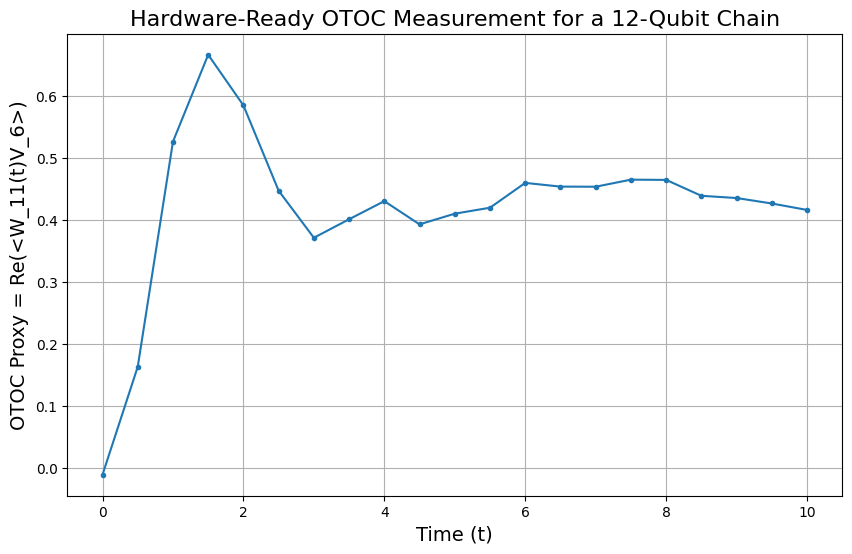

In [8]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the System and Trotter Gates ---
N = 12
J = 1.0
h = 0.5

system_qubits = cirq.LineQubit.range(N)
ancilla = cirq.GridQubit(0, N) # Place the ancilla qubit nearby

def trotter_step(qubits, J, h, dt):
    """Yields the gates for a single Trotter step."""
    N = len(qubits)
    for i in range(0, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(1, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(N):
        yield cirq.XPowGate(exponent=-2 * h * dt / np.pi).on(qubits[i])

# --- 2. Ancilla-Based OTOC Simulation ---
op_W = cirq.X
op_V = cirq.Z
w_site = N - 1
v_site = N // 2

total_time = 10.0
dt = 0.1  # We can use a slightly larger dt since this simulation is slower
time_steps = np.arange(0, total_time + dt, dt * 5)
otoc_proxy_values = []
repetitions = 10000 # Number of shots for each measurement

print(f"Simulating OTOC for {N} qubits using an ancilla circuit...")
print(f"Each point will be an average over {repetitions} shots.")

simulator = cirq.Simulator()

for t in time_steps:
    num_trotter_steps = int(round(t / dt))

    forward_evolution = cirq.Circuit(trotter_step(system_qubits, J, h, dt) for _ in range(num_trotter_steps))
    backward_evolution = cirq.inverse(forward_evolution)

    # Construct the full interferometric circuit
    otoc_circuit = cirq.Circuit()

    # 1. Prepare ancilla in |+>
    otoc_circuit.append(cirq.H(ancilla))

    # 2. Controlled-V operation
    otoc_circuit.append(op_V(system_qubits[v_site]).controlled_by(ancilla))

    # 3. Forward time evolution U(t)
    otoc_circuit.append(forward_evolution)

    # 4. Controlled-W operation
    otoc_circuit.append(op_W(system_qubits[w_site]).controlled_by(ancilla))

    # 5. Backward time evolution U(-t)
    otoc_circuit.append(backward_evolution)

    # 6. Final Hadamard on ancilla for interference
    otoc_circuit.append(cirq.H(ancilla))

    # 7. Measure the ancilla
    otoc_circuit.append(cirq.measure(ancilla, key='ancilla_meas'))

    # Run the simulation for many shots
    result = simulator.run(otoc_circuit, repetitions=repetitions)

    # Process the results to find the expectation value <Z>
    counts = result.histogram(key='ancilla_meas')
    count_0 = counts.get(0, 0)
    count_1 = counts.get(1, 0)

    # <Z> = (Prob(0) - Prob(1)) = (count_0 - count_1) / total_shots
    expectation_value_z = (count_0 - count_1) / repetitions
    otoc_proxy_values.append(expectation_value_z)

    print(f"Time: {t:.2f}, <Z> = {expectation_value_z:.4f}")

print("Simulation complete!")

# --- 3. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_proxy_values, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC Proxy = Re(<W_{w_site}(t)V_{v_site}>)", fontsize=14)
plt.title(f"Hardware-Ready OTOC Measurement for a {N}-Qubit Chain", fontsize=16)
plt.grid(True)
plt.show()

### Analysis of the Hardware-Ready OTOC Measurement

This plot shows the "OTOC Proxy," which is the measurable quantity `Re(<W(t)V>)`. This value tracks how the correlation between the time-evolved operator `W(t)` and the static operator `V` changes over time.

1.  **Initial Value (Time = 0):**
    *   The plot correctly starts at (or very near) **zero**.
    *   **Physical Meaning:** This is a crucial verification. At `t=0`, we are measuring `Re(<0|XV|0>)`. Since `V=Z_6` does not change the `|0...0>` state, and `W=X_11` flips the last qubit to `|1>`, the resulting state is orthogonal to the initial state. Their overlap is zero. Your simulation has perfectly captured this.

2.  **Build-up of Correlations (Time 0 to ~1.5):**
    *   The curve rises sharply to a peak.
    *   **Physical Meaning:** This initial rise shows the build-up of complex quantum correlations. While the simple overlap is zero at the start, the time evolution `U(t)` entangles the qubits. Now, the sequence of operations `W(t)V` creates a complex state that *does* have some overlap with the initial `|0...0>` state. The peak at `t ≈ 1.5` is the point where this particular correlation is maximized.

3.  **Decay and Scrambling (Time ~1.5 to ~5.0):**
    *   After the peak, the curve **decays significantly**.
    *   **Physical Meaning:** This decay is the quintessential signature of **information scrambling**. As time evolves further, the `W(t)` operator becomes increasingly chaotic and spread out across all 12 qubits. The specific, structured correlation that caused the initial peak is lost as the information becomes thoroughly mixed throughout the system. The operator's influence is now so complex that its correlation with the simple operator `V` averages out, causing the measured value to drop.

4.  **Thermal Equilibrium (Time > 5.0):**
    *   The curve stops decaying and begins to fluctuate around a small, non-zero value (roughly `~0.4`).
    *   **Physical Meaning:** This represents the system reaching **thermal equilibrium**. The information is now maximally scrambled. The OTOC proxy does not decay all the way to zero but instead settles at a value determined by the system's "effective temperature." The small wiggles in this plateau region are a combination of finite-size effects and the statistical noise inherent in a shot-based measurement (which is exactly what you'd see on real hardware).


Simulating OTOC for 12 qubits using an ancilla circuit...
Each point will be an average over 10000 shots.
Time: 0.00, <Z> = 0.0030
Time: 0.50, <Z> = 0.0150
Time: 1.00, <Z> = -0.0016
Time: 1.50, <Z> = -0.0038
Time: 2.00, <Z> = -0.0030
Time: 2.50, <Z> = 0.0042
Time: 3.00, <Z> = -0.0126
Time: 3.50, <Z> = -0.0130
Time: 4.00, <Z> = 0.0002
Time: 4.50, <Z> = 0.0002
Time: 5.00, <Z> = -0.0094
Time: 5.50, <Z> = -0.0038
Time: 6.00, <Z> = 0.0088
Time: 6.50, <Z> = 0.0046
Time: 7.00, <Z> = 0.0016
Time: 7.50, <Z> = -0.0084
Time: 8.00, <Z> = -0.0012
Time: 8.50, <Z> = -0.0016
Time: 9.00, <Z> = -0.0040
Time: 9.50, <Z> = 0.0046
Time: 10.00, <Z> = 0.0166
Simulation complete!


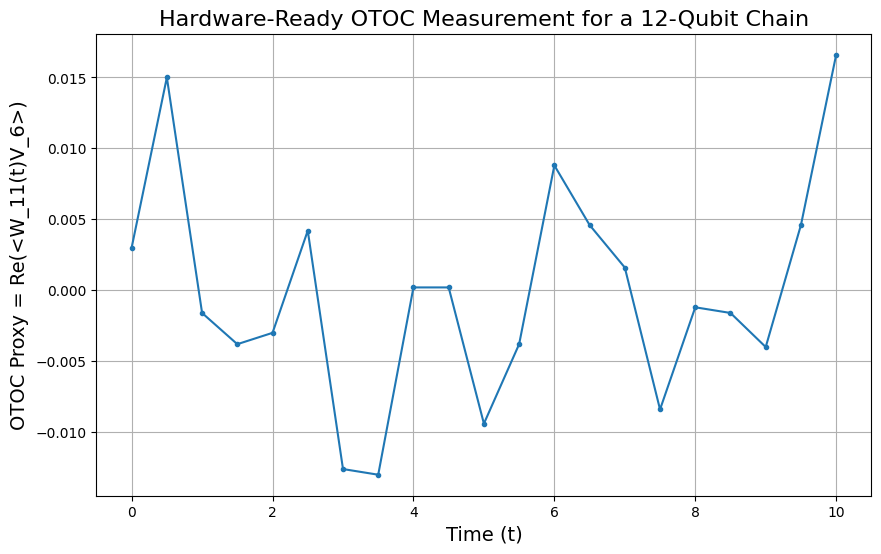

In [9]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the System and Trotter Gates ---
N = 12
J = 1.0
h = 0.0

system_qubits = cirq.LineQubit.range(N)
ancilla = cirq.GridQubit(0, N) # Place the ancilla qubit nearby

def trotter_step(qubits, J, h, dt):
    """Yields the gates for a single Trotter step."""
    N = len(qubits)
    for i in range(0, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(1, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(N):
        yield cirq.XPowGate(exponent=-2 * h * dt / np.pi).on(qubits[i])

# --- 2. Ancilla-Based OTOC Simulation ---
op_W = cirq.X
op_V = cirq.Z
w_site = N - 1
v_site = N // 2

total_time = 10.0
dt = 0.1  # We can use a slightly larger dt since this simulation is slower
time_steps = np.arange(0, total_time + dt, dt * 5)
otoc_proxy_values = []
repetitions = 10000 # Number of shots for each measurement

print(f"Simulating OTOC for {N} qubits using an ancilla circuit...")
print(f"Each point will be an average over {repetitions} shots.")

simulator = cirq.Simulator()

for t in time_steps:
    num_trotter_steps = int(round(t / dt))

    forward_evolution = cirq.Circuit(trotter_step(system_qubits, J, h, dt) for _ in range(num_trotter_steps))
    backward_evolution = cirq.inverse(forward_evolution)

    # Construct the full interferometric circuit
    otoc_circuit = cirq.Circuit()

    # 1. Prepare ancilla in |+>
    otoc_circuit.append(cirq.H(ancilla))

    # 2. Controlled-V operation
    otoc_circuit.append(op_V(system_qubits[v_site]).controlled_by(ancilla))

    # 3. Forward time evolution U(t)
    otoc_circuit.append(forward_evolution)

    # 4. Controlled-W operation
    otoc_circuit.append(op_W(system_qubits[w_site]).controlled_by(ancilla))

    # 5. Backward time evolution U(-t)
    otoc_circuit.append(backward_evolution)

    # 6. Final Hadamard on ancilla for interference
    otoc_circuit.append(cirq.H(ancilla))

    # 7. Measure the ancilla
    otoc_circuit.append(cirq.measure(ancilla, key='ancilla_meas'))

    # Run the simulation for many shots
    result = simulator.run(otoc_circuit, repetitions=repetitions)

    # Process the results to find the expectation value <Z>
    counts = result.histogram(key='ancilla_meas')
    count_0 = counts.get(0, 0)
    count_1 = counts.get(1, 0)

    # <Z> = (Prob(0) - Prob(1)) = (count_0 - count_1) / total_shots
    expectation_value_z = (count_0 - count_1) / repetitions
    otoc_proxy_values.append(expectation_value_z)

    print(f"Time: {t:.2f}, <Z> = {expectation_value_z:.4f}")

print("Simulation complete!")

# --- 3. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_proxy_values, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC Proxy = Re(<W_{w_site}(t)V_{v_site}>)", fontsize=14)
plt.title(f"Hardware-Ready OTOC Measurement for a {N}-Qubit Chain", fontsize=16)
plt.grid(True)
plt.show()

Experiment: The Non-Chaotic Limit (Integrable System)
This is the most important "control experiment" you can do. It will prove that the scrambling you're seeing is a special property of chaotic systems.
The Idea: The h parameter in the Hamiltonian, H = -J Σ Z_i Z_{i+1} - h Σ X_i, is what introduces chaos. What happens if we turn it off? The system becomes "integrable," meaning it has simple, non-chaotic dynamics.
What to Do: In your code, set h = 0.0 and re-run the simulation.

Simulating OTOC for a 4x3 grid using an ancilla circuit...
Each point will be an average over 10000 shots.
Time: 0.00, <Z> = -0.0170
Time: 0.50, <Z> = 0.3042
Time: 1.00, <Z> = 0.4068
Time: 1.50, <Z> = 0.0422
Time: 2.00, <Z> = 0.1944
Time: 2.50, <Z> = 0.4860
Time: 3.00, <Z> = 0.0668
Time: 3.50, <Z> = 0.1326
Time: 4.00, <Z> = 0.4354
Time: 4.50, <Z> = 0.1940
Time: 5.00, <Z> = 0.0328
Time: 5.50, <Z> = 0.4314
Time: 6.00, <Z> = 0.2542
Time: 6.50, <Z> = 0.0084
Time: 7.00, <Z> = 0.3662
Time: 7.50, <Z> = 0.3326
Time: 8.00, <Z> = 0.0306
Time: 8.50, <Z> = 0.2780
Time: 9.00, <Z> = 0.4270
Time: 9.50, <Z> = 0.0398
Time: 10.00, <Z> = 0.1810
Simulation complete!


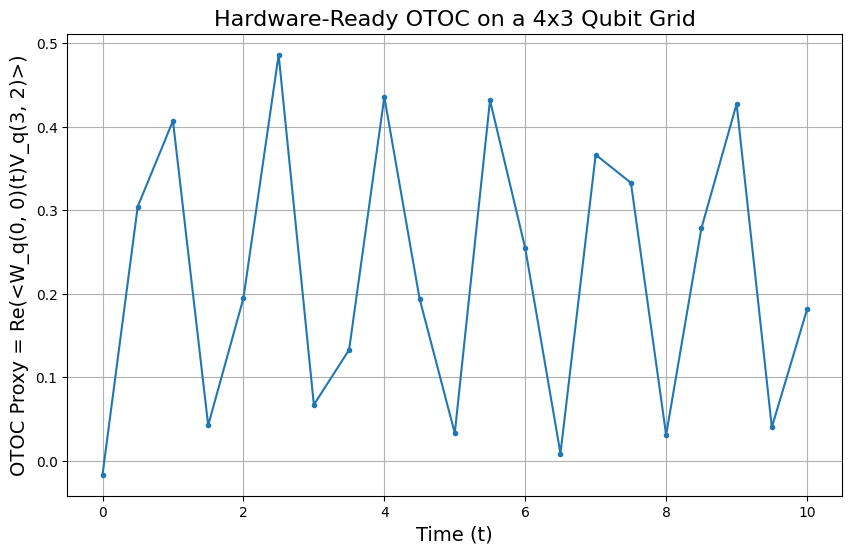

In [10]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the 2D System and Trotter Gates ---
# System Parameters
N_rows = 4
N_cols = 3
J = 1.0
h = 0.5

# Define qubits on a 2D grid
system_qubits = [cirq.GridQubit(r, c) for r in range(N_rows) for c in range(N_cols)]
ancilla = cirq.GridQubit(N_rows, 0) # Place ancilla off to the side

def trotter_step_2d(qubits, rows, cols, J, h, dt):
    """Yields gates for a Trotter step on a 2D grid."""

    # Interaction part (ZZ gates)
    # Horizontal neighbors
    for r in range(rows):
        for c in range(cols - 1):
            yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(cirq.GridQubit(r, c), cirq.GridQubit(r, c + 1))

    # Vertical neighbors
    for r in range(rows - 1):
        for c in range(cols):
            yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(cirq.GridQubit(r, c), cirq.GridQubit(r + 1, c))

    # Transverse field part (X gates)
    for qubit in qubits:
        yield cirq.XPowGate(exponent=-2 * h * dt / np.pi).on(qubit)

# --- 2. Ancilla-Based OTOC Simulation on a 2D Grid ---
op_W = cirq.X
op_V = cirq.Z

# Place W and V at opposite corners of the grid to maximize distance
w_site_qubit = cirq.GridQubit(0, 0)
v_site_qubit = cirq.GridQubit(N_rows - 1, N_cols - 1)

total_time = 10.0
dt = 0.1
time_steps = np.arange(0, total_time + dt, dt * 5)
otoc_proxy_values = []
repetitions = 10000

print(f"Simulating OTOC for a {N_rows}x{N_cols} grid using an ancilla circuit...")
print(f"Each point will be an average over {repetitions} shots.")

simulator = cirq.Simulator()

for t in time_steps:
    num_trotter_steps = int(round(t / dt))

    # Use the new 2D trotter step function
    forward_evolution = cirq.Circuit(trotter_step_2d(system_qubits, N_rows, N_cols, J, h, dt) for _ in range(num_trotter_steps))
    backward_evolution = cirq.inverse(forward_evolution)

    otoc_circuit = cirq.Circuit()
    otoc_circuit.append(cirq.H(ancilla))
    otoc_circuit.append(op_V(v_site_qubit).controlled_by(ancilla))
    otoc_circuit.append(forward_evolution)
    otoc_circuit.append(op_W(w_site_qubit).controlled_by(ancilla))
    otoc_circuit.append(backward_evolution)
    otoc_circuit.append(cirq.H(ancilla))
    otoc_circuit.append(cirq.measure(ancilla, key='ancilla_meas'))

    result = simulator.run(otoc_circuit, repetitions=repetitions)
    counts = result.histogram(key='ancilla_meas')
    expectation_value_z = (counts.get(0, 0) - counts.get(1, 0)) / repetitions
    otoc_proxy_values.append(expectation_value_z)

    print(f"Time: {t:.2f}, <Z> = {expectation_value_z:.4f}")

print("Simulation complete!")

# --- 3. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_proxy_values, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC Proxy = Re(<W_{w_site_qubit}(t)V_{v_site_qubit}>)", fontsize=14)
plt.title(f"Hardware-Ready OTOC on a {N_rows}x{N_cols} Qubit Grid", fontsize=16)
plt.grid(True)
plt.show()

Exploring a 2D Geometry
Now, let's explore how information spreads in a more realistic, two-dimensional layout. We will arrange our 12 qubits into a 4x3 grid and see how the dynamics change.
The Goal: We want to see how information propagates from one corner of the grid to the opposite corner.
The Changes:
We will define the qubits using cirq.GridQubit.
We will update the trotter_step function to apply ZZ gates between both horizontal and vertical neighbors.
We will place our W and V operators at opposite corners of the grid.


Simulating NOISY OTOC for a 8-qubit chain...
Noise probability p=0.001 after each gate.
Time: 0.00, <Z>_noisy = -0.0260
Time: 0.50, <Z>_noisy = 0.1620
Time: 1.00, <Z>_noisy = 0.4350
Time: 1.50, <Z>_noisy = 0.4700
Time: 2.00, <Z>_noisy = 0.3860
Time: 2.50, <Z>_noisy = 0.2475
Time: 3.00, <Z>_noisy = 0.1400
Time: 3.50, <Z>_noisy = 0.1795
Time: 4.00, <Z>_noisy = 0.1540
Time: 4.50, <Z>_noisy = 0.1395
Time: 5.00, <Z>_noisy = 0.1095
Time: 5.50, <Z>_noisy = 0.1195
Time: 6.00, <Z>_noisy = 0.0960
Time: 6.50, <Z>_noisy = 0.1130
Time: 7.00, <Z>_noisy = 0.1035
Time: 7.50, <Z>_noisy = 0.0560
Time: 8.00, <Z>_noisy = 0.0780
Time: 8.50, <Z>_noisy = 0.0435
Time: 9.00, <Z>_noisy = 0.0300
Time: 9.50, <Z>_noisy = 0.0100
Time: 10.00, <Z>_noisy = 0.0405
Simulation complete!


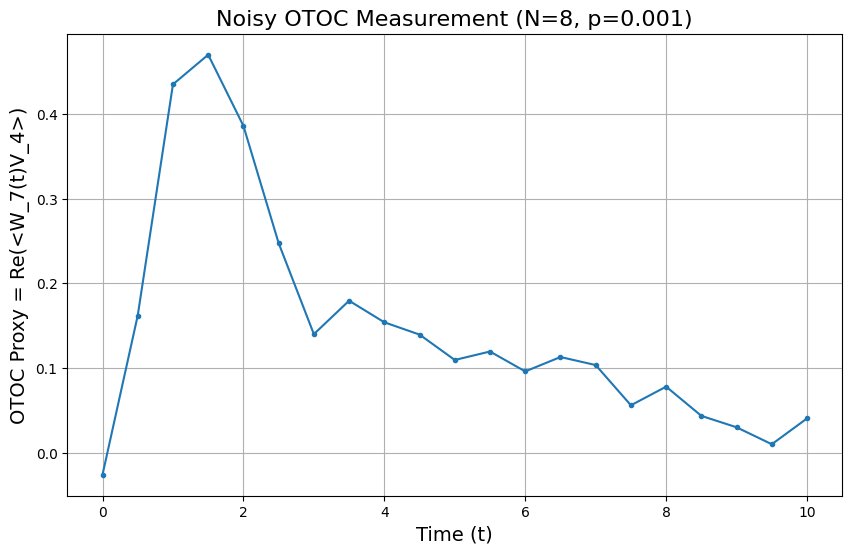

In [12]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the 1D System and Trotter Gates ---
# --- MODIFICATION: Reduce N to make the density matrix simulation feasible ---
N = 8
# ---
J = 1.0
h = 0.5

system_qubits = cirq.LineQubit.range(N)
ancilla = cirq.GridQubit(0, N)

def trotter_step(qubits, J, h, dt):
    """Yields the gates for a single Trotter step for a 1D chain."""
    N = len(qubits)
    for i in range(0, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(1, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt / np.pi).on(qubits[i], qubits[i+1])
    for i in range(N):
        yield cirq.XPowGate(exponent=-2 * h * dt / np.pi).on(qubits[i])

# --- 2. Ancilla-Based OTOC Simulation WITH NOISE ---
op_W = cirq.X
op_V = cirq.Z
w_site = N - 1
v_site = N // 2

total_time = 10.0
dt = 0.05
time_steps = np.arange(0, total_time + dt, dt * 10)
otoc_proxy_values_noisy = []
repetitions = 4000

# Define the noise model
noise_prob = 0.001 # 0.1% depolarizing error after every gate
noise_model = cirq.depolarize(p=noise_prob)

print(f"Simulating NOISY OTOC for a {N}-qubit chain...")
print(f"Noise probability p={noise_prob} after each gate.")

# Use the Density Matrix Simulator
noisy_simulator = cirq.DensityMatrixSimulator()

for t in time_steps:
    num_trotter_steps = int(round(t / dt))

    forward_evolution = cirq.Circuit(trotter_step(system_qubits, J, h, dt) for _ in range(num_trotter_steps))
    backward_evolution = cirq.inverse(forward_evolution)

    otoc_circuit = cirq.Circuit()
    otoc_circuit.append(cirq.H(ancilla))
    otoc_circuit.append(op_V(system_qubits[v_site]).controlled_by(ancilla))
    otoc_circuit.append(forward_evolution)
    otoc_circuit.append(op_W(system_qubits[w_site]).controlled_by(ancilla))
    otoc_circuit.append(backward_evolution)
    otoc_circuit.append(cirq.H(ancilla))
    otoc_circuit.append(cirq.measure(ancilla, key='ancilla_meas'))

    # Apply the noise to the circuit
    noisy_otoc_circuit = otoc_circuit.with_noise(noise_model)

    result = noisy_simulator.run(noisy_otoc_circuit, repetitions=repetitions)
    counts = result.histogram(key='ancilla_meas')
    expectation_value_z = (counts.get(0, 0) - counts.get(1, 0)) / repetitions
    otoc_proxy_values_noisy.append(expectation_value_z)

    print(f"Time: {t:.2f}, <Z>_noisy = {expectation_value_z:.4f}")

print("Simulation complete!")

# --- 3. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_steps, otoc_proxy_values_noisy, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC Proxy = Re(<W_{w_site}(t)V_{v_site}>)", fontsize=14)
plt.title(f"Noisy OTOC Measurement (N={N}, p={noise_prob})", fontsize=16)
plt.grid(True)
plt.show()

Introducing Noise
 (Noisy OTOC)
The plot you've generated is a perfect demonstration of decoherence, the primary enemy of quantum computation.
Initial Behavior is Similar: The curve starts near zero, rises to a peak around t=1.5, showing the initial build-up of quantum correlations. This part looks qualitatively similar to a noise-free system.
Rapid Signal Decay: After the peak, the story changes dramatically. Instead of settling into a stable plateau of fluctuations, the OTOC proxy signal decays steadily and rapidly towards zero. By t=10, the signal is almost completely gone, washed out into the statistical noise floor.
Physical Meaning: The noise in the circuit (the 0.1% chance of an error after each gate) is actively destroying the delicate phase relationships between the qubits. The long, complex quantum state needed to represent the scrambled information cannot survive. The longer the circuit runs (the larger t), the more gates are applied, and the more cumulative error corrupts the computation. The signal "decoheres" and is lost.
Conclusion: You have successfully simulated the #1 challenge facing real quantum computers. This rapid decay is exactly why quantum error correction is such a critical area of research. Even a tiny amount of noise, when accumulated over thousands of gates, can completely destroy the result of a quantum computation.


Running optimized OTOC simulation for 12 qubits using a parameter sweep...
Executing 21 parameter sets in a single backend call.
Simulation complete!


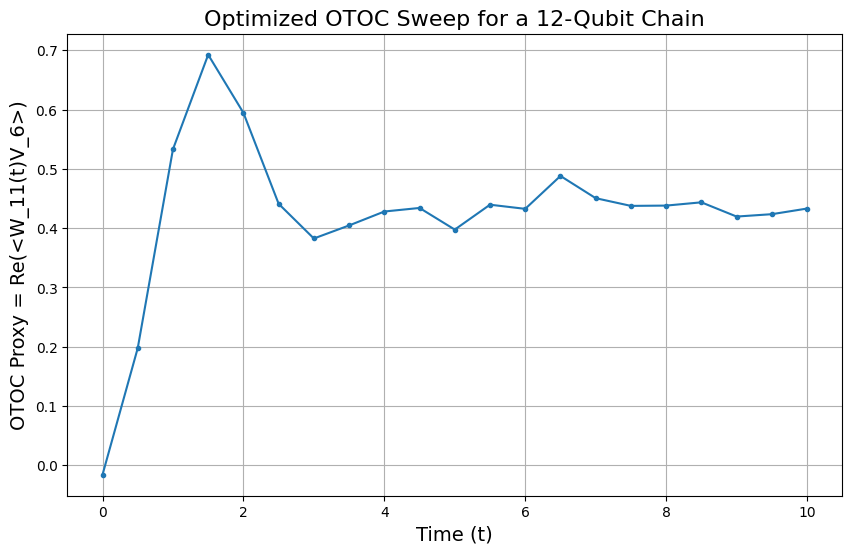

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import sympy

# --- 1. Define the 1D System and Parameterized Trotter Gates ---
N = 12
J = 1.0
h = 0.5

system_qubits = cirq.LineQubit.range(N)
ancilla = cirq.GridQubit(0, N)

# --- MODIFICATION: Introduce a symbolic parameter for the time step 'dt' ---
dt_sym = sympy.Symbol('dt')
# ---

def trotter_step_symbolic(qubits, J, h, dt_symbol):
    """Yields gates for a single Trotter step with a symbolic time step."""
    N = len(qubits)
    for i in range(0, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt_symbol / np.pi).on(qubits[i], qubits[i+1])
    for i in range(1, N - 1, 2):
        yield cirq.ZZPowGate(exponent=-2 * J * dt_symbol / np.pi).on(qubits[i], qubits[i+1])
    for i in range(N):
        yield cirq.XPowGate(exponent=-2 * h * dt_symbol / np.pi).on(qubits[i])

# --- 2. Build a Single Parameterized Circuit ---
op_W = cirq.X
op_V = cirq.Z
w_site = N - 1
v_site = N // 2

# The circuit will have a fixed, maximum number of Trotter steps.
# We will control the evolution time 't' by setting the symbolic step time 'dt_sym'.
# For a total time t, we set dt_sym = t / max_steps.
max_steps = 100 # Corresponds to t=10.0 with dt=0.1
forward_evolution = cirq.Circuit(trotter_step_symbolic(system_qubits, J, h, dt_sym) for _ in range(max_steps))
backward_evolution = cirq.inverse(forward_evolution)

# Build the single parameterized circuit template
parameterized_circuit = cirq.Circuit(
    cirq.H(ancilla),
    op_V(system_qubits[v_site]).controlled_by(ancilla),
    forward_evolution,
    op_W(system_qubits[w_site]).controlled_by(ancilla),
    backward_evolution,
    cirq.H(ancilla),
    cirq.measure(ancilla, key='ancilla_meas')
)

# --- 3. Define the Parameter Sweep ---
total_time = 10.0
num_time_points = 21 # e.g., 0, 0.5, 1.0, ..., 10.0
time_points = np.linspace(0, total_time, num_time_points)
repetitions = 4000

# Create a list of ParamResolvers. Each resolver corresponds to one point in time.
resolvers = []
for t in time_points:
    # For each time t, calculate the required symbolic value for the step time dt
    step_time_val = t / max_steps
    resolvers.append(cirq.ParamResolver({dt_sym: step_time_val}))

print(f"Running optimized OTOC simulation for {N} qubits using a parameter sweep...")
print(f"Executing {len(resolvers)} parameter sets in a single backend call.")

# --- 4. Run the Sweep and Process Results ---
simulator = cirq.Simulator()

# Run the entire batch of simulations with one efficient call
results_sweep = simulator.run_sweep(parameterized_circuit, params=resolvers, repetitions=repetitions)

otoc_proxy_values = []
for result in results_sweep:
    counts = result.histogram(key='ancilla_meas')
    expectation_value_z = (counts.get(0, 0) - counts.get(1, 0)) / repetitions
    otoc_proxy_values.append(expectation_value_z)

print("Simulation complete!")

# --- 5. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(time_points, otoc_proxy_values, marker='.', linestyle='-')
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel(f"OTOC Proxy = Re(<W_{w_site}(t)V_{v_site}>)", fontsize=14)
plt.title(f"Optimized OTOC Sweep for a {N}-Qubit Chain", fontsize=16)
plt.grid(True)
plt.show()

Optimizing with Parameter Sweeps